In [1]:
# coding: utf-8

# In[1]:

import numpy as np
#import h5py
#import tensorflow as tf
#import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.layers import Input,Conv2D,Concatenate,Flatten,Dense,LeakyReLU,Dropout, ReLU
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.python.keras.models import Model


from tensorflow.python.keras import backend as K

from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint

from sklearn.model_selection import train_test_split
import cv2

#from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
#from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.python.keras.models import Sequential
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
fn = 2
d_min = 1
d_max = 10
blur_filter_size = 11
blur_range = 10
image_size = 512
epochs = 300#0
batch_size = 32

In [3]:
# train_data_path = 'train_data_uint8_512_10000_vcm_alpha.npy'
# test_data_path = 'real_data_uint8_512_vcm_10000_alpha.npy'
# train_label_path = 'train_label_uint8_512_10000_vcm_alpha.npy'
# test_label_path = 'real_label_uint8_512_vcm_10000_alpha.npy'

train_data_path = 'train_data_8000_raw.npy'
test_data_path = 'real_data_uint8_512_vcm_10000_alpha.npy'
train_label_path = 'train_label_8000_raw.npy'
test_label_path = 'real_label_uint8_512_vcm_10000_alpha.npy'

In [4]:
train_data = np.load(train_data_path)
test_data = np.load(test_data_path)
train_label = np.load(train_label_path)
test_label = np.load(test_label_path)

In [5]:
print(train_data.shape)
print(train_label.shape)
test_data = test_data[1::2, :, :, :]
test_label = test_label[1::2, :]

(8000, 512, 512, 1)
(8000, 2)


In [6]:
# def pre_normalize(im):
#     # https://www.learnopencv.com/image-quality-assessment-brisque/
#     blurred = cv2.GaussianBlur(im, (7, 7), 1.166) # apply gaussian blur to the image
#     blurred_sq = blurred * blurred
#     sigma = cv2.GaussianBlur(im * im, (7, 7), 1.166) 
#     sigma = (sigma - blurred_sq) ** 0.5
#     sigma = sigma + 1.0/255 # to make sure the denominator doesn't give DivideByZero Exception
#     structdis = (im - blurred)/sigma # final MSCN(i, j) image
#     t = im - blurred
#     t = (t-t.min())/(t.max() - t.min())
#     return t

# for iii in range(train_data.shape[0]):
#     train_data[iii, :, :, 0] = pre_normalize(train_data[iii, :, :, 0].astype(np.float32))

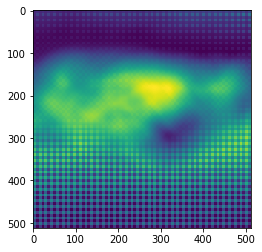

[1.    1.098]


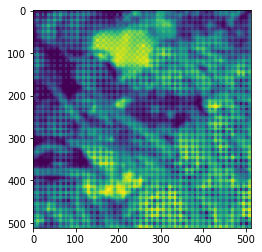

[1.    1.013]


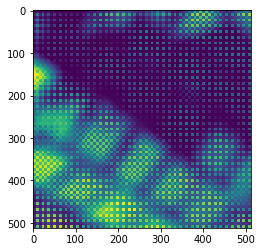

[1.    1.049]


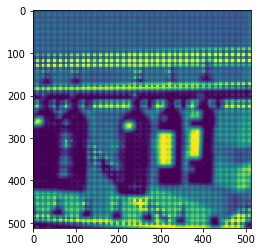

[1.   1.02]


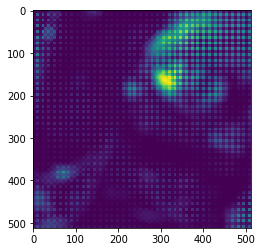

[1.    0.966]


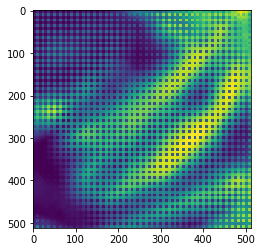

[1.    0.934]


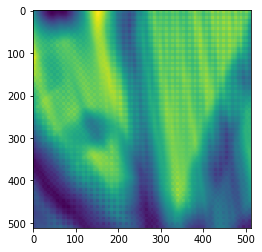

[1.    0.911]


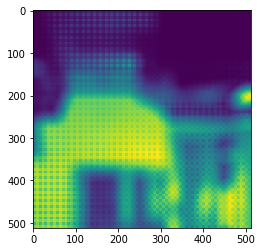

[1.    1.043]


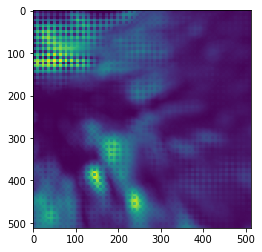

[1.    1.033]


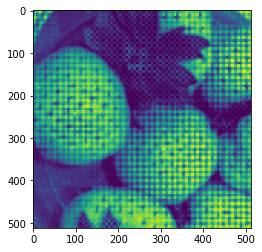

[1.    0.986]
float16


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
for idx in range(10):
    plt.imshow(train_data[idx, :, :, 0].astype(np.float32))
    plt.show()
    print(train_label[idx, :])
print(train_data.dtype)
# batch_features = np.zeros((image_size//2, image_size//2, 4))
# batch_features[:, :, 0] = train_data[idx, 1::2, ::2, 0]
# batch_features[:, :, 1] = train_data[idx, ::2, ::2, 0]
# batch_features[:, :, 2] = train_data[idx, 1::2, 1::2, 0]
# batch_features[:, :, 3] = train_data[idx, ::2, 1::2, 0]
# plt.imshow(batch_features[:, :, 3]*16383)

[1.   1.02 0.  ]


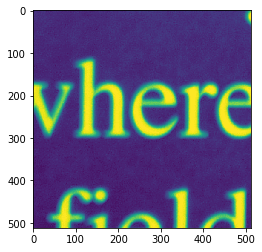

In [8]:
plt.imshow(test_data[idx, :, :, 0])
print(test_label[idx, :])

In [9]:
# In[7]:
input_image1 = Input(shape=(256, 256, 4), name = "input")

layer1_1 = Conv2D(4, (9, 9), 4,padding='same',activation=relu, name="Conv1_1")(input_image1)

layer2_1 = Conv2D(8, (5, 5), 2,padding='same',activation=relu, name="Conv2_1")(layer1_1)
dp0_1 = Dropout(0.25)(layer2_1)

layer3_1 = Conv2D(16, (5, 5), 2,padding='same',activation=relu, name="Conv3_1")(dp0_1)

layer4_1 = Conv2D(32, (5, 5), 2,padding='same',activation=relu, name="Conv4_1")(layer3_1)
dp0_2 = Dropout(0.25)(layer4_1)

flattened = Flatten(name="flat")(dp0_2)
# dense1 = Dense(1024, name="d1")(flattened)
# ReLU1 = LeakyReLU(0.1, name="lr1")(dense1)
# dp1 = Dropout(0.5)(ReLU1)

dense2 = Dense(256, name="d2")(flattened)
ReLU2 = LeakyReLU(0.1, name="lr2")(dense2)
dp2 = Dropout(0.5)(ReLU2)

dense3 = Dense(64, name="d3")(dp2)
ReLU3 = LeakyReLU(0.1, name="lr3")(dense3)
dp3 = Dropout(0.5)(ReLU3)

output_position = Dense(1, name="out")(ReLU3)
print(output_position)

model = Model(inputs=input_image1, outputs=output_position)
model.summary()

tcbc = TensorBoard(log_dir='1')

filepath="raw_models/gen/n_{epoch:03d}-{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='max',period=2)

print(model.output_shape)

Tensor("out/BiasAdd:0", shape=(?, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 256, 256, 4)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 64, 64, 4)         1300      
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 32, 32, 8)         808       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
_________________________________________________________________
Conv3_1 (Conv2D)             (None, 16, 16, 16)        3216      
_________________________________________________________________
Conv4_1 (Conv2D)             (None, 8, 8, 32)          12832     
_________________________________________________________________
dropout_1 (Dropout)    

In [10]:
def data_gen(features, labels, batch_size):
    while True:
        for i in np.arange(0, features.shape[0] - batch_size, batch_size):
            # choose random index in features
            ################!!!
            batch_features = np.zeros((batch_size, image_size//2, image_size//2, 4))
            batch_features[:, :, :, 0] = features[i:i+batch_size, 1::2, ::2, 0]
            batch_features[:, :, :, 1] = features[i:i+batch_size, ::2, ::2, 0]
            batch_features[:, :, :, 2] = features[i:i+batch_size, 1::2, 1::2, 0]
            batch_features[:, :, :, 3] = features[i:i+batch_size, ::2, 1::2, 0]
            #batch_features = features[i:i+batch_size, :, :, :]
            batch_features = batch_features.astype('float16')#/255###########################
            batch_labels = abs(labels[i:i+batch_size, 1:2] - labels[i:i+batch_size, :1])*100
            yield (batch_features, batch_labels)

In [11]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001)
model.compile(loss='mse', optimizer=opt)

X_train, X_test, y_train, y_test = train_test_split(
    train_data, train_label, test_size=0.2, random_state=233)

# model.fit(train_data[:,:,:,0:1].astype('float16')/255.0, abs(train_label[:,1:2]-train_label[:,0:1])/100, 
#           epochs = 100,batch_size = batch_size, #validation_split=0.2,
#           validation_data=(test_data[:,:,:,0:1].astype('float16')/255.0, abs(test_label[:,1:2]-test_label[:,0:1])/100), 
#           verbose=1, callbacks = [tcbc, checkpoint])
model.fit_generator(data_gen(X_train, y_train, batch_size), 
                    steps_per_epoch = X_train.shape[0]/batch_size, epochs = epochs,
                    validation_data=data_gen(X_test, y_test, batch_size), 
                    validation_steps = batch_size,verbose=1, callbacks = [tcbc, checkpoint])

Epoch 1/300
200/200 [==============================] - 17s 87ms/step - loss: 4.0726 - val_loss: 2.5512
Epoch 2/300
199/200 [============================>.] - ETA: 0s - loss: 2.0551
Epoch 00002: saving model to raw_models/gen/n_002-1.682.hdf5
200/200 [==============================] - 16s 82ms/step - loss: 2.0498 - val_loss: 1.6817
Epoch 3/300
200/200 [==============================] - 16s 81ms/step - loss: 1.6387 - val_loss: 1.5797
Epoch 4/300
199/200 [============================>.] - ETA: 0s - loss: 1.4831
Epoch 00004: saving model to raw_models/gen/n_004-1.431.hdf5
200/200 [==============================] - 16s 82ms/step - loss: 1.4812 - val_loss: 1.4308
Epoch 5/300
200/200 [==============================] - 16s 80ms/step - loss: 1.3461 - val_loss: 1.1038
Epoch 6/300
199/200 [============================>.] - ETA: 0s - loss: 1.1811
Epoch 00006: saving model to raw_models/gen/n_006-0.978.hdf5
200/200 [==============================] - 16s 80ms/step - loss: 1.1811 - val_loss: 0.9782
E

Epoch 99/300
200/200 [==============================] - 16s 80ms/step - loss: 0.1734 - val_loss: 0.6441
Epoch 100/300
199/200 [============================>.] - ETA: 0s - loss: 0.1671
Epoch 00100: saving model to raw_models/gen/n_100-0.609.hdf5
200/200 [==============================] - 16s 80ms/step - loss: 0.1673 - val_loss: 0.6093
Epoch 101/300
200/200 [==============================] - 16s 82ms/step - loss: 0.1676 - val_loss: 0.4902
Epoch 102/300
199/200 [============================>.] - ETA: 0s - loss: 0.1650
Epoch 00102: saving model to raw_models/gen/n_102-0.581.hdf5
200/200 [==============================] - 17s 83ms/step - loss: 0.1652 - val_loss: 0.5807
Epoch 103/300
200/200 [==============================] - 16s 81ms/step - loss: 0.1662 - val_loss: 0.5642
Epoch 104/300
199/200 [============================>.] - ETA: 0s - loss: 0.1543
Epoch 00104: saving model to raw_models/gen/n_104-0.468.hdf5
200/200 [==============================] - 17s 83ms/step - loss: 0.1548 - val_los

199/200 [============================>.] - ETA: 0s - loss: 0.1264
Epoch 00148: saving model to raw_models/gen/n_148-0.568.hdf5
200/200 [==============================] - 16s 82ms/step - loss: 0.1263 - val_loss: 0.5681
Epoch 149/300
200/200 [==============================] - 16s 81ms/step - loss: 0.1296 - val_loss: 0.5390
Epoch 150/300
199/200 [============================>.] - ETA: 0s - loss: 0.1255
Epoch 00150: saving model to raw_models/gen/n_150-0.483.hdf5
200/200 [==============================] - 16s 81ms/step - loss: 0.1263 - val_loss: 0.4829
Epoch 151/300
200/200 [==============================] - 16s 82ms/step - loss: 0.1226 - val_loss: 0.5505
Epoch 152/300
199/200 [============================>.] - ETA: 0s - loss: 0.1245
Epoch 00152: saving model to raw_models/gen/n_152-0.540.hdf5
200/200 [==============================] - 16s 81ms/step - loss: 0.1245 - val_loss: 0.5395
Epoch 153/300
200/200 [==============================] - 16s 82ms/step - loss: 0.1212 - val_loss: 0.4779
Epo

Epoch 197/300
200/200 [==============================] - 16s 82ms/step - loss: 0.0996 - val_loss: 0.5593
Epoch 198/300
199/200 [============================>.] - ETA: 0s - loss: 0.1033
Epoch 00198: saving model to raw_models/gen/n_198-0.548.hdf5
200/200 [==============================] - 16s 82ms/step - loss: 0.1032 - val_loss: 0.5479
Epoch 199/300
200/200 [==============================] - 16s 80ms/step - loss: 0.1020 - val_loss: 0.4820
Epoch 200/300
199/200 [============================>.] - ETA: 0s - loss: 0.1064
Epoch 00200: saving model to raw_models/gen/n_200-0.543.hdf5
200/200 [==============================] - 16s 81ms/step - loss: 0.1061 - val_loss: 0.5434
Epoch 201/300
200/200 [==============================] - 16s 81ms/step - loss: 0.0994 - val_loss: 0.5312
Epoch 202/300
199/200 [============================>.] - ETA: 0s - loss: 0.1004
Epoch 00202: saving model to raw_models/gen/n_202-0.461.hdf5
200/200 [==============================] - 16s 81ms/step - loss: 0.1004 - val_lo

Epoch 246/300
199/200 [============================>.] - ETA: 0s - loss: 0.0879
Epoch 00246: saving model to raw_models/gen/n_246-0.514.hdf5
200/200 [==============================] - 16s 80ms/step - loss: 0.0880 - val_loss: 0.5138
Epoch 247/300
200/200 [==============================] - 16s 80ms/step - loss: 0.0874 - val_loss: 0.5165
Epoch 248/300
199/200 [============================>.] - ETA: 0s - loss: 0.0868
Epoch 00248: saving model to raw_models/gen/n_248-0.490.hdf5
200/200 [==============================] - 16s 80ms/step - loss: 0.0871 - val_loss: 0.4897
Epoch 249/300
200/200 [==============================] - 16s 81ms/step - loss: 0.0843 - val_loss: 0.5237
Epoch 250/300
199/200 [============================>.] - ETA: 0s - loss: 0.0831
Epoch 00250: saving model to raw_models/gen/n_250-0.515.hdf5
200/200 [==============================] - 16s 81ms/step - loss: 0.0832 - val_loss: 0.5152
Epoch 251/300
200/200 [==============================] - 16s 80ms/step - loss: 0.0854 - val_lo

Epoch 295/300
200/200 [==============================] - 16s 82ms/step - loss: 0.0793 - val_loss: 0.5165
Epoch 296/300
199/200 [============================>.] - ETA: 0s - loss: 0.0789
Epoch 00296: saving model to raw_models/gen/n_296-0.515.hdf5
200/200 [==============================] - 16s 81ms/step - loss: 0.0788 - val_loss: 0.5153
Epoch 297/300
200/200 [==============================] - 16s 82ms/step - loss: 0.0784 - val_loss: 0.4714
Epoch 298/300
199/200 [============================>.] - ETA: 0s - loss: 0.0769
Epoch 00298: saving model to raw_models/gen/n_298-0.524.hdf5
200/200 [==============================] - 16s 81ms/step - loss: 0.0769 - val_loss: 0.5236
Epoch 299/300
200/200 [==============================] - 16s 82ms/step - loss: 0.0803 - val_loss: 0.5210
Epoch 300/300
199/200 [============================>.] - ETA: 0s - loss: 0.0783
Epoch 00300: saving model to raw_models/gen/n_300-0.469.hdf5
200/200 [==============================] - 16s 81ms/step - loss: 0.0782 - val_lo

In [12]:
# model.save('my_model_512.h5')

In [13]:
# print(train_label[:, :10])

In [14]:
# from tensorflow.python.keras.models import load_model
# model = load_model('models/050-0.65.hdf5')

In [15]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# idxx = 89
# plt.imshow(test_data[idxx, :, :, 0])
# print(test_label[idxx, :])

In [16]:
# model.predict(test_data[idxx:idxx+1, :, :, :1]/255.0)

ValueError: could not broadcast input array from shape (0,256,256) into shape (64,256,256)

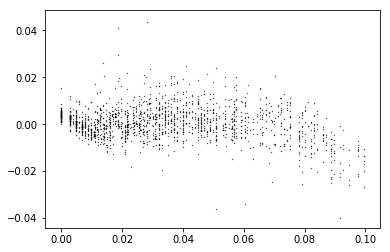

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(2000//64-1): #
    batch_features = np.zeros((64, image_size//2, image_size//2, 4))
    batch_features[:, :, :, 0] = X_test[64*i:64*i+64, 1::2, ::2, 0]
    batch_features[:, :, :, 1] = X_test[64*i:64*i+64, ::2, ::2, 0]
    batch_features[:, :, :, 2] = X_test[64*i:64*i+64, 1::2, 1::2, 0]
    batch_features[:, :, :, 3] = X_test[64*i:64*i+64, ::2, 1::2, 0]
    test_pred = model.predict(batch_features)
    test_pred[test_pred<0]= 0
    plt.scatter(abs(y_test[64*i:64*i+64, 0] - y_test[64*i:64*i+64, 1]), test_pred[:, 0]/100 - abs(y_test[64*i:64*i+64, 0] - y_test[64*i:64*i+64, 1]), color='black', s = 0.1)
plt.show()
# for i in range(8000//64-1): #
#     train_pred = model.predict(train_data[64*i:64*i+64, :, :, :1]/255.0)
#     train_pred[train_pred<0]= 0
#     plt.scatter(abs(train_label[64*i:64*i+64, 0] - train_label[64*i:64*i+64, 1]), train_pred[:, 0]/100 - abs(train_label[64*i:64*i+64, 0] - train_label[64*i:64*i+64, 1]), color='black', s = 0.1)
# plt.show()

In [ ]:
# test_pred[test_pred<0]= 0
# print(test_pred[:, 0])

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.imshow(test_data[0, :, :, 0])
# print(test_label)

In [ ]:
# plt.scatter(abs(test_label[:, 0] - test_label[:, 1]), test_pred[:, 0])